# C4021 - Project
## Group 2.4
Gerry Kerley
### Dataset used
Titanic passenger survival: 
https://www.kaggle.com/c/titanic/data

## Data Loading & Preprocessing

### Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Load Titanic dataset

In [2]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

train.info()
train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
833,834,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,347468,7.8542,NaN,S
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,9234,7.7500,NaN,Q
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S


## Data Cleaning

### Check for missing data

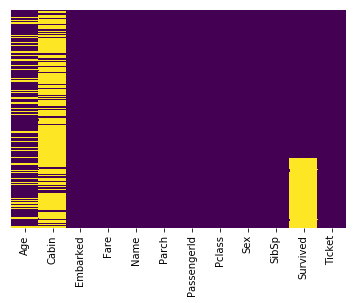

In [3]:
combined_data = pd.concat([train, test])
sns.heatmap(combined_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Age & Cabin have a lot of missing data.

Cabin number is probably not that important.

### Fill missing Age data
Check whether the 3 passenger classes have different age distributions

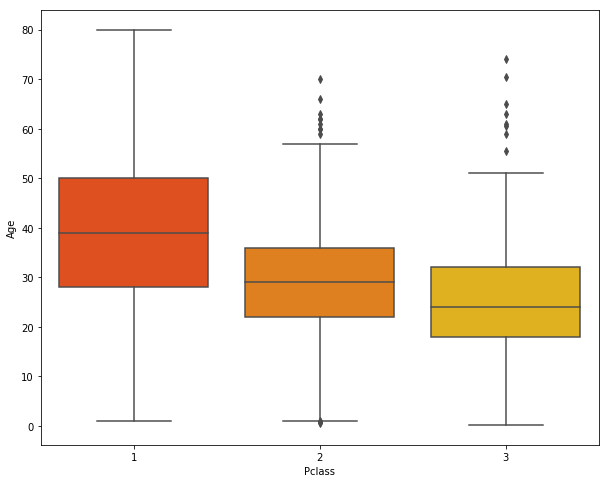

In [4]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Pclass',y='Age',data=combined_data,palette='autumn')

1st class tends to have older passengers so we can use the mean age for each class to fill in the blank ages.

In [5]:
def fill_missing_ages_with_mean_for_pclass (cols):
    Age = cols[0]
    Pclass = cols[1]   
          
    if pd.isnull(Age): 
        
        if Pclass == 1:            
            return np.mean(combined_data[combined_data['Pclass'] == 1 ]['Age'])

        elif Pclass == 2:
            return np.mean(combined_data[combined_data['Pclass'] == 2 ]['Age'])

        else:
            return np.mean(combined_data[combined_data['Pclass'] == 3 ]['Age'])

    else:
        return Age
    
combined_data['Age'] = combined_data[['Age','Pclass']].apply(fill_missing_ages_with_mean_for_pclass, axis=1)
combined_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


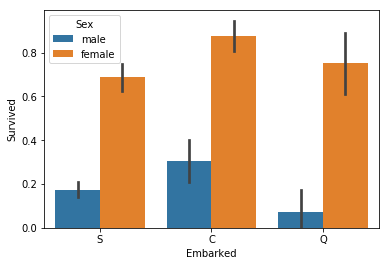

In [7]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=combined_data);

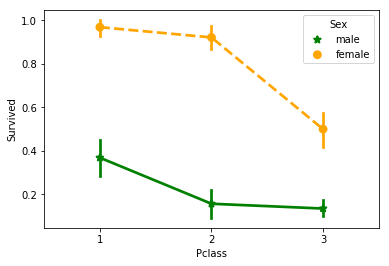

In [8]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=combined_data,
              palette={"male": "green", "female": "orange"},
              markers=["*", "o"], linestyles=["-", "--"]);

## Feature Engineering

In [9]:
def prepare_features(data):
    # Age
    data.Age = data.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 20, 25, 40, 65, 120)
    categories = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    age_groups = pd.cut(data.Age, bins, labels=categories)
    data.Age = age_groups
    
    # TODO: categorise fares, split name?, cabin numbers?
    #data.Fare = data.Fare.fillna(-0.5)
    data.fillna(value={'Fare': np.mean(data['Fare'])}, inplace=True)
    
    # TODO: Convert Pclass to Social Class
    
    # Drop columns
    unwanted_cols = ['Embarked', 'Ticket', 'Name', 'Cabin']
    data.drop(unwanted_cols, axis=1, inplace= True)

    return data

combined_data = prepare_features(combined_data)
combined_data.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,Student,7.2500,0,1,3,male,1,0.0
1,Young Adult,71.2833,0,2,1,female,1,1.0
2,Young Adult,7.9250,0,3,3,female,0,1.0
3,Young Adult,53.1000,0,4,1,female,1,1.0
4,Young Adult,8.0500,0,5,3,male,0,0.0


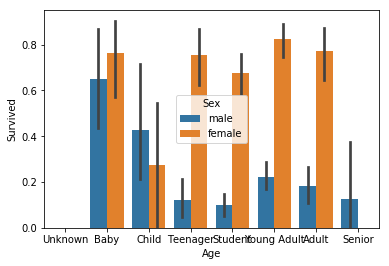

In [10]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=combined_data);

### Normalise labels
Use SKLearn's LabelEncoder to convert each unique string value into a number

In [11]:
def encode_features(combined_data):
    features = ['Age', 'Sex']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(combined_data[feature])
        combined_data[feature] = le.transform(combined_data[feature])
    return combined_data
    
combined_data = encode_features(combined_data)
print(combined_data.head())

   Age     Fare  Parch  PassengerId  Pclass  Sex  SibSp  Survived
0    4   7.2500      0            1       3    1      1       0.0
1    6  71.2833      0            2       1    0      1       1.0
2    6   7.9250      0            3       3    0      0       1.0
3    6  53.1000      0            4       1    0      1       1.0
4    6   8.0500      0            5       3    1      0       0.0


#### Feature heatmap

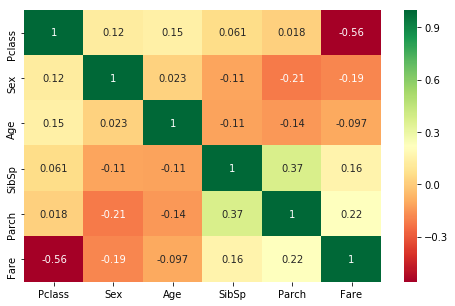

In [12]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
X = combined_data[features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

## Training 
#### Split the Training Data

In [13]:
train_data = combined_data[combined_data['Survived'].notnull()]
test_data = combined_data[combined_data['Survived'].isnull()]
test_data = test_data.drop('Survived', axis=1)

X_all = train_data.drop(['Survived', 'PassengerId'], axis=1)
y_all = train_data['Survived']

test_proportion = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=test_proportion, random_state=42)

In [14]:
X_test.head()

,Age,Fare,Parch,Pclass,Sex,SibSp
709,4,15.2458,1,3,1,1
439,6,10.5000,0,2,1,0
840,5,7.9250,0,3,1,0
720,2,33.0000,1,2,0,0
39,5,11.2417,0,3,0,1


## Machine Learning
#### Fit, predict and fine tune the algorithms

### Logistic Regression

In [15]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
log_reg.score(X_train, y_train)

0.7963483146067416

In [17]:
lr_predictions = log_reg.predict(X_test)
lr_predictions

array([0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 1.])

In [18]:
confusion_matrix = confusion_matrix(y_test, lr_predictions)
confusion_matrix

array([[89, 16],
       [22, 52]])

In [19]:
print(accuracy_score(y_test, lr_predictions))

0.7877094972067039


#### Cross Validation

In [20]:
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.69444444 0.70422535 0.75714286 0.76056338 0.76056338 0.76388889
 0.84507042 0.84722222 0.9        0.93055556]
0.7963676503465236


#### Evaluation

In [21]:
print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82       105
         1.0       0.76      0.70      0.73        74

   micro avg       0.79      0.79      0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



### Random Forest

In [22]:
rf_clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 7, 10], 
              'max_features': ['log2', 'sqrt', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

scorer = make_scorer(accuracy_score)

grid_search = GridSearchCV(rf_clf, parameters, scoring=scorer)
grid_search = grid_search.fit(X_train, y_train)

rf_clf = grid_search.best_estimator_

rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
rf_predictions = rf_clf.predict(X_test)
print(accuracy_score(y_test, rf_predictions))

0.7821229050279329


### Predict on Test Data

In [24]:
ids = test_data['PassengerId']

predictions = rf_clf.predict(test_data.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
# output.to_csv('titanic/titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0.0
1,893,1.0
2,894,0.0
3,895,0.0
4,896,1.0
